<a href="https://colab.research.google.com/github/saeedmehrang/Tensorflow_Keras/blob/master/Classify_images_of_flowers_with_transfer_learning_InceptionV3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

     |████████████████████████████████| 228.9MB 149kB/s 
     |████████████████████████████████| 512kB 7.2MB/s 
     |████████████████████████████████| 4.3MB 50.8MB/s 
     |████████████████████████████████| 61kB 30.2MB/s 
  Created wheel for opt-einsum: filename=opt_einsum-2.3.2-cp36-none-any.whl size=49882 sha256=e44c0174103f7dc408de3fca00422a1723d26070dc3341b7833a1929abd5f233
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built opt-einsum
     |████████████████████████████████| 81kB 9.5MB/s 
  Found existing installation: tensorflow-hub 0.5.0
    Uninstalling tensorflow-hub-0.5.0:
      Successfully uninstalled tensorflow-hub-0.5.0
     |████████████████████████████████| 942kB 8.8MB/s 


W0807 14:35:26.216866 140307978639232 __init__.py:687] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


# Download the Flowers Dataset using TensorFlow Datasets


In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(70, 30))

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split = splits)

num_examples = dataset_info.splits['train'].num_examples

num_classes = dataset_info.features['label'].num_classes



# Import the InceptionV3 pre-trained weights and biases except for the last layer




### Perform Transfer Learning with the Inception Model

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) and click on `tf2-preview/inception_v3/feature_vector`. This feature vector corresponds to the Inception v3 model. In the cells below, use transfer learning to create a CNN that uses Inception v3 as the pretrained model to classify the images from the Flowers dataset. Note that Inception, takes as input, images that are 299 x 299 pixels. Compare the accuracy you get with Inception v3 to the accuracy you got with MobileNet v2.

# Reformat Images and Create Batches


In [0]:
IMAGE_RES = 299

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = training_set.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES,3))

### Freeze the Pre-Trained Model


In [0]:
feature_extractor.trainable = False

### Create a model

In [0]:
def create_model():
  model = tf.keras.Sequential()
  model.add(feature_extractor)
  model.add(layers.Dense(num_classes, activation='softmax'))

  return model

model = create_model() 

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


### Train the model

In [13]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
81/81 [==============================] - 40s 492ms/step - loss: 1.2547 - acc: 0.6309 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/20
81/81 [==============================] - 17s 212ms/step - loss: 0.8339 - acc: 0.8216 - val_loss: 0.7073 - val_acc: 0.8389
Epoch 3/20
81/81 [==============================] - 17s 208ms/step - loss: 0.7112 - acc: 0.8564 - val_loss: 0.6592 - val_acc: 0.8528
Epoch 4/20
81/81 [==============================] - 17s 206ms/step - loss: 0.6465 - acc: 0.8761 - val_loss: 0.6351 - val_acc: 0.8620
Epoch 5/20
81/81 [==============================] - 17s 208ms/step - loss: 0.6026 - acc: 0.8892 - val_loss: 0.6183 - val_acc: 0.8639
Epoch 6/20
81/81 [==============================] - 17s 209ms/step - loss: 0.5691 - acc: 0.8992 - val_loss: 0.6055 - val_acc: 0.8667
Epoch 7/20
81/81 [==============================] - 17s 209ms/step - loss: 0.5418 - acc: 0.9077 - val_loss: 0.5956 - val_acc: 0.8704
Epoch 8/20
81/81 [==============================] - 17s 209ms


# Plot Training and Validation Graphs.


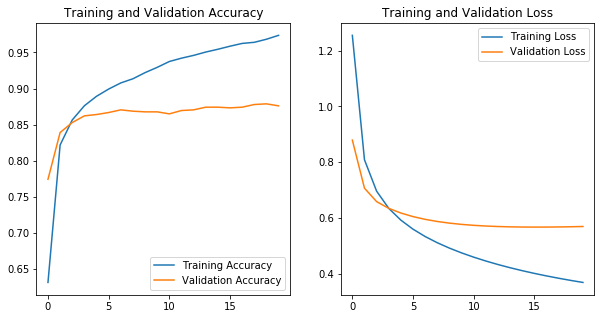

In [14]:
def plot_history(history):
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = np.arange(len(history.history['loss']))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  #plt.savefig('./foo.png')
  plt.show()
  
########################
  
plot_history(history)

## check the predictions 

In [15]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [16]:
### each one of the following items is a tensor
image_batch, label_batch = next(iter(train_batches))

### tensors can be transformed into numpy array by calling the .numpy() method
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

### predict the labels and squeeze them into a two dimensional array
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

print('Shape of the predictions for the taken batch',predicted_batch.shape)

predicted_ids = np.argmax(predicted_batch, axis=-1) ## get the biggest element index 
predicted_class_names = class_names[predicted_ids]

print('Predicted class indices',predicted_ids)
print('Predicted class labels', predicted_class_names)

Shape of the predictions for the taken batch (32, 5)
Predicted class indices [1 4 2 2 1 3 3 0 4 2 0 0 0 0 0 2 2 0 3 0 3 4 4 2 0 4 4 2 0 2 2 0]
Predicted class labels ['daisy' 'roses' 'tulips' 'tulips' 'daisy' 'sunflowers' 'sunflowers'
 'dandelion' 'roses' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'dandelion' 'tulips' 'tulips' 'dandelion' 'sunflowers'
 'dandelion' 'sunflowers' 'roses' 'roses' 'tulips' 'dandelion' 'roses'
 'roses' 'tulips' 'dandelion' 'tulips' 'tulips' 'dandelion']


In [17]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [1 4 2 2 1 3 3 0 4 2 0 0 0 0 0 2 2 0 3 0 3 4 4 2 0 4 4 2 0 2 2 0]
Predicted labels:  [1 4 2 2 1 3 3 0 4 2 0 0 0 0 0 2 2 0 3 0 3 4 4 2 0 4 4 2 0 2 2 0]


# Plot Model Predictions


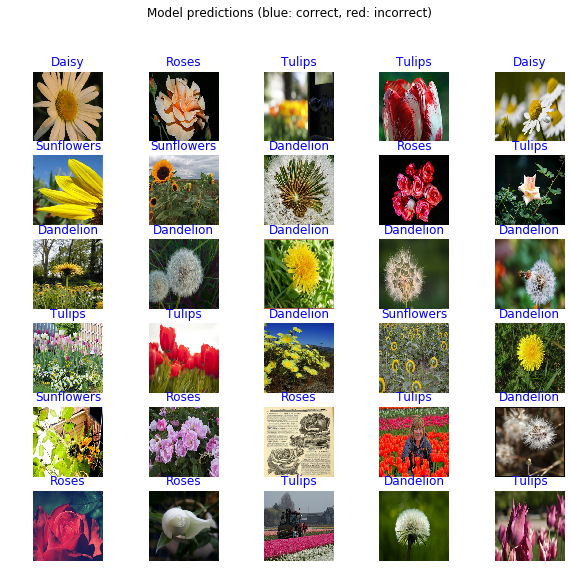

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")